<a id="0"></a> <br>
## **Table of Contents**
* [Quantum Teleportation](#1)
* [Superdense Coding](#2)
* [The CHSH Game](#3)

In [61]:
# Required Imports
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi, random
from numpy.random import randint

<a id="1"></a> 

<a id='1'></a>
## Quantum Teleportation

Here is a quantum circuit implementation of the teleportation protocol.

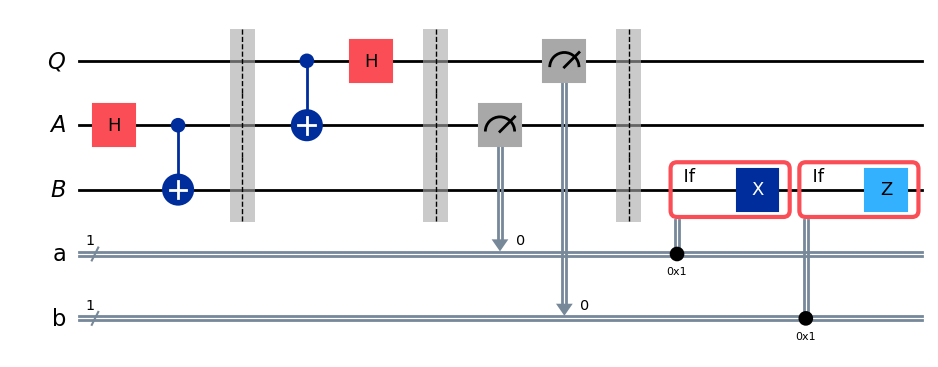

In [62]:
qubit = QuantumRegister(1, "Q")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")
a = ClassicalRegister(1, "a")
b = ClassicalRegister(1, "b")

protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Prepare ebit used for teleportation
protocol.h(ebit0)
protocol.cx(ebit0, ebit1)
protocol.barrier()

# Alice's operations
protocol.cx(qubit, ebit0)
protocol.h(qubit)
protocol.barrier()

# Alice measures and sends classical bits to Bob
protocol.measure(ebit0, a)
protocol.measure(qubit, b)
protocol.barrier()

# Bob uses the classical bits to conditionally apply gates
with protocol.if_test((a, 1)):
    protocol.x(ebit1)
with protocol.if_test((b, 1)):
    protocol.z(ebit1)

display(protocol.draw(output='mpl'))

 The `barrier` function creates a visual separation making the circuit diagram more readable, and it also prevents Qiskit from performing various simplifications and optimizations across barriers during compilation when circuits are run on real hardware. The `if_test` function applies an operation conditionally depending on a classical bit or register.

The circuit first initializes $(A,B)$ to be in a $∣\phi^{+}⟩$ bell state (which is not part of the protocol itself), followed by Alice's operations, then her measurements, and finally Bob's operations. Remember that by convention, Qiskit initializes all qubits in the $∣0⟩$ state when they are created.

To test that the protocol works correctly, we'll apply a randomly generated single-qubit gate to the initialized $∣0⟩$ state of $Q$ to obtain a random quantum state vector to be teleported. By applying the inverse (i.e., conjugate transpose) of that gate to $B$ after the protocol is run, we can verify that the state was teleported by measuring to see that it has returned to the $∣0⟩$ state.

First we'll randomly choose a unitary qubit gate.

In [63]:
random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi,
)

display(random_gate.to_matrix())

array([[ 0.05991516+0.j        ,  0.79747982-0.60036331j],
       [-0.31845721+0.94604185j, -0.01888148-0.05686226j]])

Now we'll create a new testing circuit that first applies our random gate to $Q$ then runs the teleportation circuit, and finally applies the inverse of our random gate to the qubit $B$ and measures. The outcome should be 0 with certainty.

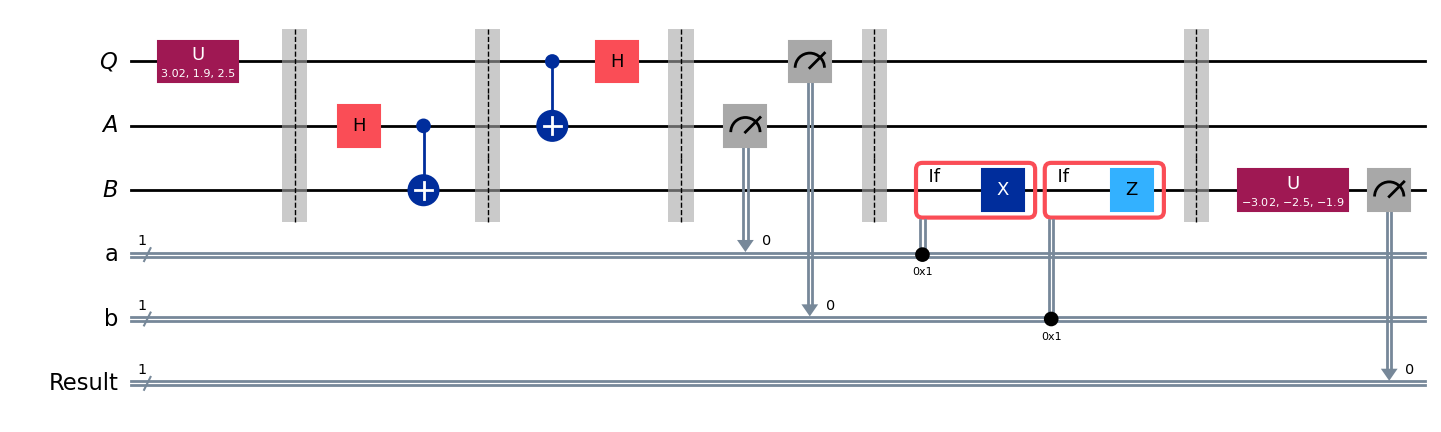

In [64]:
# Create a new circuit including the same bits and qubits used in the teleportation protocol
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Start with the randomly selected gate on Q
test.append(random_gate, qubit)
test.barrier()

# Append the entire teleportation protocol from above
test = test.compose(protocol)
test.barrier()

# Finally, apply the inverse of the random unitary to B and measure
test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

display(test.draw(output='mpl'))

Finally let's run the Aer simulator on this circuit and plot a histogram of the outputs. We'll see the statistics for all three classical bits: the bottom/leftmost bit should always be 0, indicating that the qubit Q was successfully teleported into B, while the other two bits should be roughly uniform.

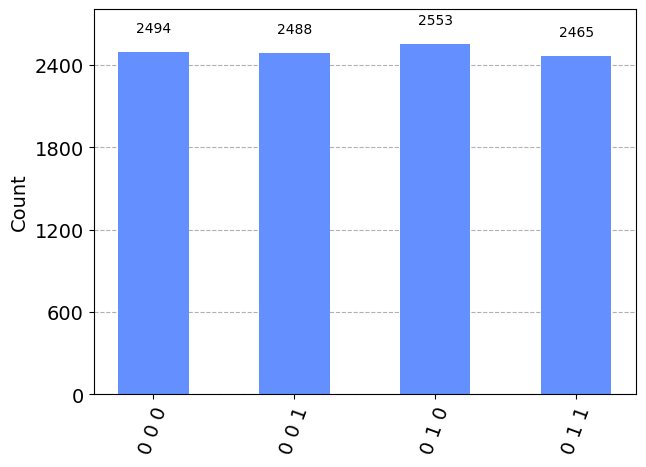

In [65]:
result = AerSimulator().run(test, shots=10000).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

We can also filter the statistics to focus just on the test result qubit if we wish, like this:

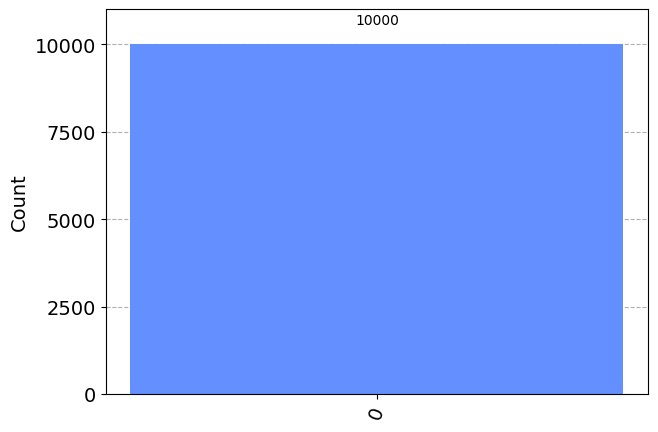

In [66]:
filtered_statistics = marginal_distribution(statistics, [2])
display(plot_histogram(filtered_statistics))

<a id='2'></a>
## Superdense Coding

Here is a simple implementation of superdense coding where we specify the circuit itself depending on the bits to be transmitted. First let's specify the bits to be transmitted. (Try changing the bits to see that it works correctly.)

In [67]:
c = "1"
d = "0"

Now we'll build the circuit accordingly. Here we'll just allow Qiskit to use the default names for the qubits: $q_0$ for the top qubit and $q_1$ for the bottom one.

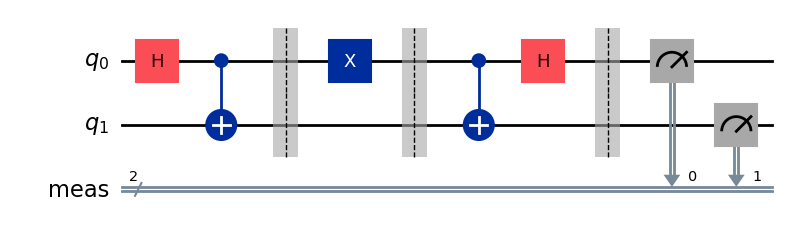

In [68]:
protocol = QuantumCircuit(2)

# Prepare ebit used for superdense coding
protocol.h(0)
protocol.cx(0, 1)
protocol.barrier()

# Alice's operations
if d == "1":
    protocol.z(0)
if c == "1":
    protocol.x(0)
protocol.barrier()

# Bob's actions
protocol.cx(0, 1)
protocol.h(0)
protocol.measure_all()

display(protocol.draw(output='mpl'))

Not much is new here, except the `measure_all` function, which measures all of the qubits and puts the results into a single classical register (therefore having two bits in this case).

Running the Aer simulator produces the expected output.

Measured 10 with frequency 1.0


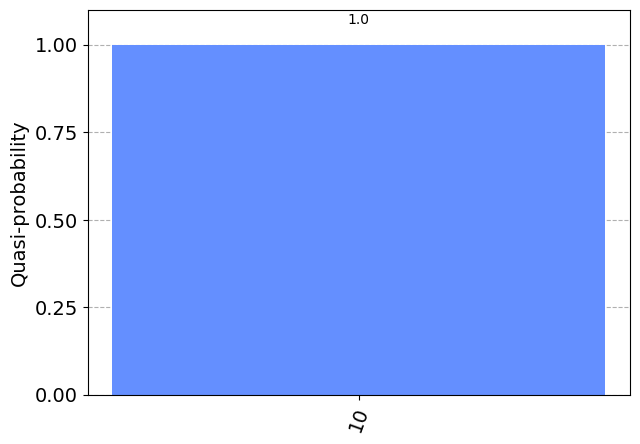

In [69]:
result = Sampler().run(protocol, shots=10000).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, freq in statistics.items():
    print(f"Measured {outcome} with frequency {freq}")
    
display(plot_histogram(statistics))

Just for fun, we can use an additional qubit as a random bit generator to randomly choose $c$ and $d$, then run the superdense coding protocol to see that these bits are transmitted correctly.

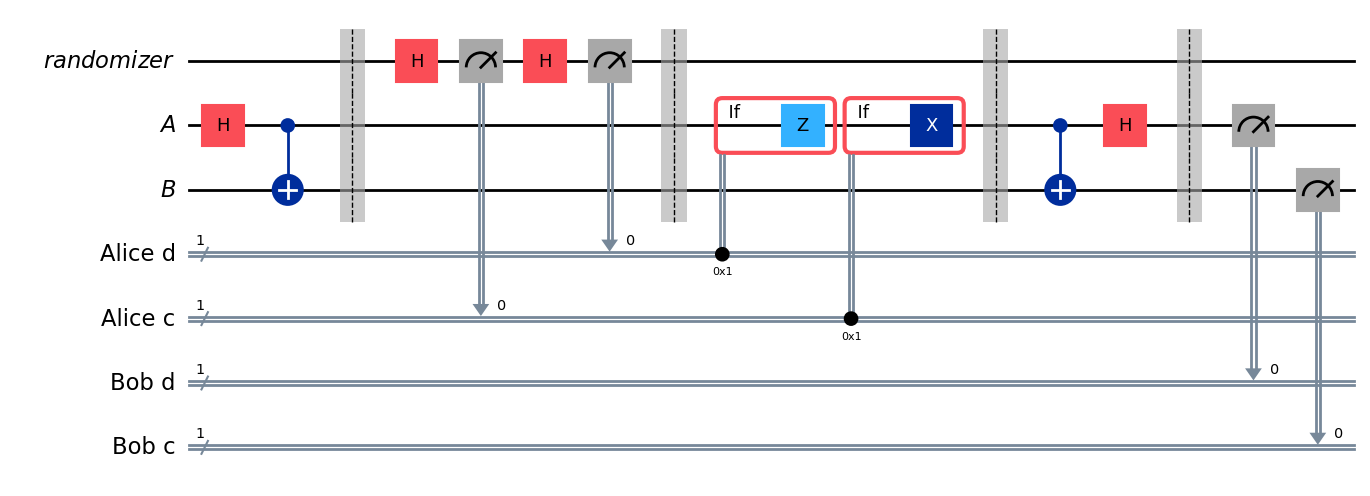

In [70]:
rbg = QuantumRegister(1, "randomizer")
ebit0 = QuantumRegister(1, "A")
ebit1 = QuantumRegister(1, "B")

Alice_c = ClassicalRegister(1, "Alice c")
Alice_d = ClassicalRegister(1, "Alice d")

test = QuantumCircuit(rbg, ebit0, ebit1, Alice_d, Alice_c)

# Initialize the ebit
test.h(ebit0)
test.cx(ebit0, ebit1)
test.barrier()

# Use the 'randomizer' qubit twice to generate Alice's bits c and d.
test.h(rbg)
test.measure(rbg, Alice_c)
test.h(rbg)
test.measure(rbg, Alice_d)
test.barrier()

# Now the protocol runs, starting with Alice's actions, which depend
# on her bits.
with test.if_test((Alice_d, 1), label="Z"):
    test.z(ebit0)
with test.if_test((Alice_c, 1), label="X"):
    test.x(ebit0)
test.barrier()

# Bob's actions
test.cx(ebit0, ebit1)
test.h(ebit0)
test.barrier()

Bob_c = ClassicalRegister(1, "Bob c")
Bob_d = ClassicalRegister(1, "Bob d")
test.add_register(Bob_d)
test.add_register(Bob_c)
test.measure(ebit0, Bob_d)
test.measure(ebit1, Bob_c)

display(test.draw(output='mpl'))


Running the Aer simulator shows the results: Alice and Bob's classical bits always agree.

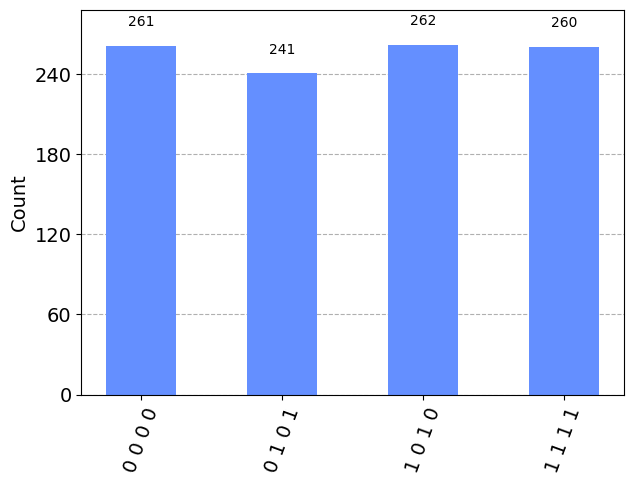

In [71]:
result = AerSimulator().run(test).result()
statistics = result.get_counts()
display(plot_histogram(statistics))

<a id='3'></a>
## The CHSH Game

We can implement the CHSH game together with a quantum strategy in Qiskit as follows.

First, here's the definition of the game itself, which allows an arbitrary strategy to be plugged in as an argument.

In [72]:
def chsh_game(strategy):
    """
    Summary:
        plays the CHSH game.
    Args:
        strategy (callable): A function that takes two bits (as `int`s) and
            returns two bits (also as `int`s). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss.
    """
    # Referee chooses x and y randomly
    x, y = randint(0, 2), randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

Now we'll create a function that outputs a circuit depending on the questions for Alice and Bob. We'll let the qubits have their default names for simplicity, and we'll use the built-in $R_{y}(\theta)$ gate for Alice and Bob's actions.

In [73]:
def chsh_circuit(x, y):
    """
    Summary:
        Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

Here are the four possible circuits, depending on which questions are asked.

(x,y) = (0,0)


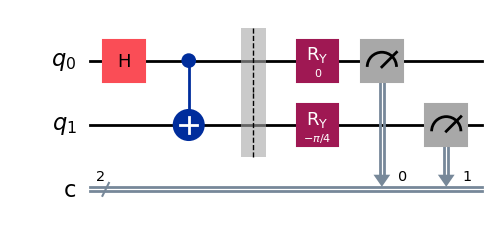

(x,y) = (0,1)


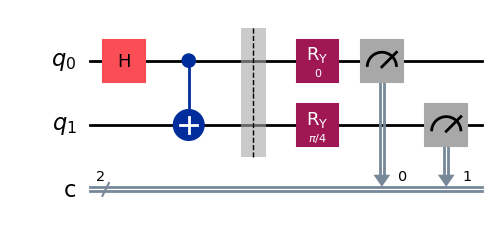

(x,y) = (1,0)


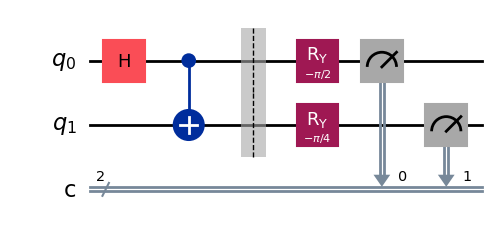

(x,y) = (1,1)


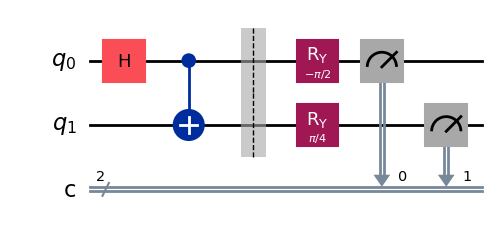

In [74]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw(output='mpl'))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw(output='mpl'))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw(output='mpl'))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw(output='mpl'))

Now we'll create a job using the Aer simulator that runs the circuit a single time for a given input pair $(x,y)$.

In [75]:
sampler = Sampler()

def quantum_strategy(x, y):
    """
    Summary:
        Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # `shots=1` runs the circuit once
    result = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

Finally, we'll play the game 1,000 times and compute the fraction of them that the strategy wins.

In [76]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(quantum_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.861


We can also define a classical strategy and see how well it works (it should not work as well as our quantum strategy!).

In [77]:
def classical_strategy(x, y):
    """An optimal classical strategy for the CHSH game
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # Alice's answer
    if x == 0:
        a = 0
    elif x == 1:
        a = 1

    # Bob's answer
    if y == 0:
        b = 1
    elif y == 1:
        b = 0

    return a, b

Again let's play the game 1,000 times to see how well it works.

In [78]:
NUM_GAMES = 1000
TOTAL_SCORE = 0

for _ in range(NUM_GAMES):
    TOTAL_SCORE += chsh_game(classical_strategy)

print("Fraction of games won:", TOTAL_SCORE / NUM_GAMES)

Fraction of games won: 0.727
